In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

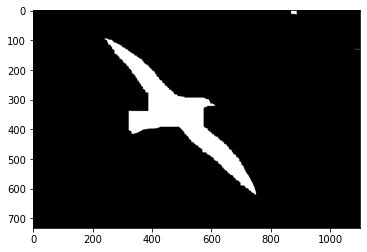

In [2]:
image = "../data/bird.jpg"
img = cv2.imread(image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

edge = cv2.Canny(img,240,255)
dilated = cv2.dilate(edge,None,iterations = 20)
eroded = cv2.erode(dilated,None,iterations = 30)
plt.imshow(eroded,cmap="gray")

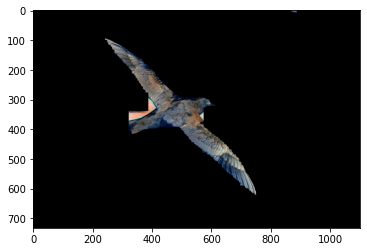

In [3]:
masked = img.copy()
for i in range(3):
    masked[:,:,i] = img[:,:,i]*eroded
plt.imshow(masked)

In [7]:
import cv2
import numpy as np
import sys,os
from tqdm import tqdm

# script_dir = sys.path[0] # This gives the directory in which our script is running on the system
# img_path = os.path.join(script_dir, '../data/'+sys.argv[1])


def im2double(im,d):
    #im1,im2,im3 = cv2.split(im)
#     out = im.copy()
#     for i in range(d):
#         out[:,:,i] = (out[:,:,i] - np.min(out[:,:,i]))/(np.max(out[:,:,i])-np.min(out[:,:,i]))
    
    im1 = im[:,:,0]
    im2 = im[:,:,1]
    im3 = im[:,:,2]
    out1 = (im1.astype(np.float64) - np.min(im1.ravel())) / (np.max(im1.ravel()) - np.min(im1.ravel()))
    out2 = (im2.astype(np.float64) - np.min(im2.ravel())) / (np.max(im2.ravel()) - np.min(im2.ravel()))
    out3 = (im3.astype(np.float64) - np.min(im3.ravel())) / (np.max(im3.ravel()) - np.min(im3.ravel()))
    out = cv2.merge((out1,out2,out3))
    return out

def meanShift(img):
    r,c,d = img.shape
    img = im2double(img,d)
    gaussian_blur = cv2.GaussianBlur(img, (5,5), 1.0)
    
    #hsv_image = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    #h,s,v = cv2.split(hsv_image)
#     row = r//2
#     col = row
    row,col = 128,128
    newimg = cv2.resize(img,(row,col))

    
    result1 = np.zeros((row,col))
    result2 = np.zeros((row,col))
    result3 = np.zeros((row,col))
    h=0.1
    sigma = 11.0 
    count = 0
    window_size = 7
    padded = np.concatenate((np.concatenate((np.zeros((row,window_size,3)), newimg),axis=1), np.zeros((row,window_size,3))),axis=1)

    padded = np.concatenate((np.concatenate((np.zeros((window_size,col+2*(window_size),3)),padded),axis=0), np.zeros((window_size, col+2*(window_size),3))),axis=0)
    #padded = np.zeros((row+2*window_size,col+2*window_size))
    r,c,d = padded.shape
    #r,c = padded.shape
    print(padded.shape)

    #isotropic
    #Spatial
    spatial = np.zeros((2*window_size+1,2*window_size+1))
    for is1 in range(2*window_size+1):
        for is2 in range(2*window_size+1):
            spatial[is1][is2] = ((is1-window_size)**2+(is2-window_size)**2)**0.5
    spatial = np.exp(-(spatial/sigma)**2)

    
    for idx1 in tqdm(range(window_size,r-window_size)):
        for idx2 in range(window_size,c-window_size):
            window = padded[idx1-window_size:idx1+window_size+1, idx2-window_size:idx2+window_size+1]
            #print(newimg[idx1][idx2])
            (x1,x2,x3) = newimg[idx1-window_size][idx2-window_size]
            N1 = 0.0 #numerator
            D1 = 1.0 #denominator
            N2 = 0.0 #numerator
            D2 = 1.0 #denominator
            N3 = 0.0 #numerator
            D3 = 1.0 #denominator


            for itern in range(30): # number of iterations
                for idx3 in range(2*window_size+1):
                    for idx4 in range(2*window_size+1):
                        (x_i1,x_i2,x_i3) = window[idx3][idx4]
                        diff1 = abs(x1-x_i1)
                        diff2 = abs(x2-x_i2)
                        diff3 = abs(x3-x_i3)

                        d1 = np.exp(-(diff1/h)**2)*spatial[idx3][idx4]
                        n1 = x_i1*d1
                        N1 += n1
                        D1 += d1

                        d2 = np.exp(-(diff2/h)**2)*spatial[idx3][idx4]
                        n2 = x_i2*d2
                        N2 += n2
                        D2 += d2

                        d3 = np.exp(-(diff3/h)**2)*spatial[idx3][idx4]
                        n3 = x_i3*d3
                        N3 += n3
                        D3 += d3

                x1 = float(N1)/D1 # in each iteration, x changes
                x2 = float(N2)/D2 # in each iteration, x changes
                x3 = float(N3)/D3 # in each iteration, x changes

            result1[idx1-window_size][idx2-window_size] = x1
            result2[idx1-window_size][idx2-window_size] = x2
            result3[idx1-window_size][idx2-window_size] = x3

#             if count%1000 == 0:
#                 print(count)
#             count += 1
    '''
    cv2.imshow('Original Image',spatial)
    print(spatial)
    '''
    result = cv2.merge((result1,result2,result3))
    #print(result)
    return result,newimg

In [5]:
# img = cv2.imread("../data/bird.jpg") # Read image here
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# meanShift(img)

  0%|          | 0/128 [00:00<?, ?it/s]

(142, 142, 3)


100%|██████████| 128/128 [25:49<00:00, 12.10s/it]


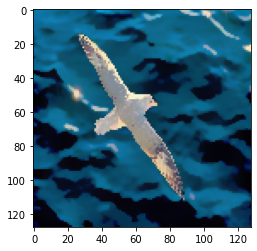

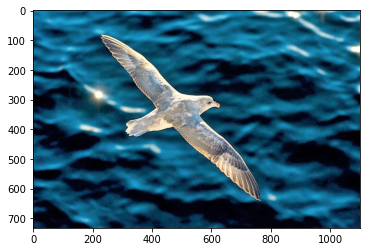

In [8]:
img = cv2.imread("../data/bird.jpg") # Read image here
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result2,resized_image = meanShift(img)
plt.figure()
plt.imshow(result2)
plt.figure()
plt.imshow(img)

(732, 1100, 3)


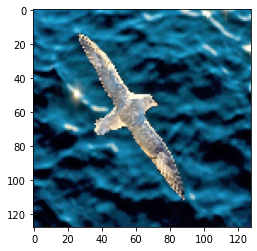

In [48]:
resized_orig = cv2.resize(img,(128,128))
plt.imshow(resized_orig)
print(img.shape)

In [ ]:
flower_img = cv2.imread("../data/flower.jpg") # Read image here
flower_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result1 = meanShift(flower_img)
plt.figure()
plt.imshow(result1)
plt.figure()
plt.imshow(flower_img)

(128, 128, 3)


NameError: name 'unique_intensities' is not defined

100%|██████████| 128/128 [00:00<00:00, 13721.94it/s]


[(0.665027, 6285), (0.30663, 10097)]
2


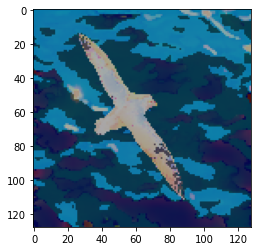

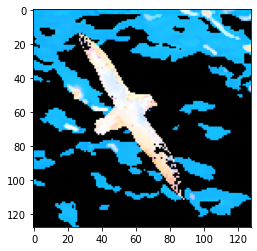

In [38]:
#print(np.unique(result[:,:,0]))
masked = np.zeros_like(result2)
# for i in range(3):
#     for j in range(64):
#         for k in range(64):
#             if result[j,k,i]>0.7:
#                 masked[j,k,i] = 1
#             else:
#                 masked[j,k,i] = 0

unique_intensities ={}

result = (result2).astype(np.float32)
#print(result.shape)

hsv_result = cv2.cvtColor(result,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv_result)

r,c = v.shape
diff = np.zeros_like(v)

for i in tqdm(range(r)):
    for j in range(c):
        inten = v[i,j]
        flag=0
        if inten not in unique_intensities:
            diff = 999999
            intensity = 0
            for k in unique_intensities:
                if abs(inten-k)<0.35:
                    flag=1
                    if diff>abs(inten-k):
                        diff = abs(inten-k)
                        intensity=k 
                    v[i,j] = intensity
            if flag==0:
                unique_intensities[inten] = 0
            else:
                unique_intensities[intensity] += 1
        else:
            unique_intensities[inten] += 1

sort =sorted(unique_intensities.items(), key = lambda kv:(kv[1], kv[0])) 
print(sort)
h_copy = np.ones_like(h)
s_copy = np.ones_like(s)
v_copy = v.copy()
for i in tqdm(range(r)):
    for j in range(c):
        if v_copy[i,j]==sort[-1][0]:
            v_copy[i,j] = 0
        else:
            v_copy[i,j] = 1


"""
for z in range(3):
    for i in range(64):
        for j in range(64):
            inten = result[i,j,z]
            flag=0
            if inten not in unique_intensities:
                for k in unique_intensities:
                    if abs(inten-k)<0.25:
                        masked[i,j,z] = k
                        flag=1
                        break
                if flag==0:
                    unique_intensities.append(inten) 

"""
masked = cv2.merge((h,s,v))
masked_2 = cv2.merge((h,s,v_copy))
masked = cv2.cvtColor(masked,cv2.COLOR_HSV2RGB)
masked_2 = cv2.cvtColor(masked_2,cv2.COLOR_HSV2RGB)
plt.figure()
plt.imshow(masked)
plt.figure()
plt.imshow(masked_2)
print(len(unique_intensities))
# for key,value in unique_intensities.items():
#     print(key," : ", value)
#print(np.unique(masked,axis=0))

(128, 128, 3)
0.001441497428714634


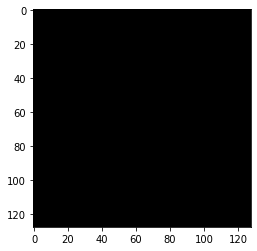

In [39]:
print(result2.shape)
print(((sort[-1][0])**3)*0.05)
r,col,d = result2.shape
result_copy = np.zeros_like(result2)
for i in range(r):
    for j in range(col):
        a,b,c = result_copy[i,j,:]
        #print(a*b*c)
        if a*b*c<=(((sort[0][0])**3)):
            result_copy[i,j,:] = 0

plt.imshow(result_copy)

(128, 128)
1611


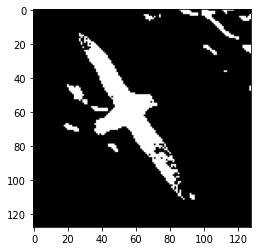

In [40]:
r,c,d = masked_2.shape
vectorized_mask = np.zeros((r,c))
foreground_pixels = []
for i in range(r):
    for j in range(c):
            vectorized_mask[i,j] = masked_2[i,j,0] * masked_2[i,j,1] * masked_2[i,j,2]
            if vectorized_mask[i,j]>0.4:   #0.02 works for flower , 0.4 for bird
                vectorized_mask[i,j]=1
                foreground_pixels.append((i,j))
            else:
                vectorized_mask[i,j]=0
print(vectorized_mask.shape)

plt.imshow(vectorized_mask,cmap='gray')
print(len(foreground_pixels))
#print(vectorized_mask)

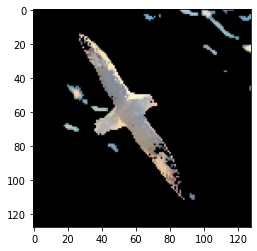

In [41]:
masked_img = np.zeros((result2.shape[0],result2.shape[1],3))
masked_img[:,:,0] = result2[:,:,0]*vectorized_mask
masked_img[:,:,1] = result2[:,:,1]*vectorized_mask
masked_img[:,:,2] = result2[:,:,2]*vectorized_mask
plt.imshow(masked_img)

100%|██████████| 128/128 [00:58<00:00,  2.18it/s]


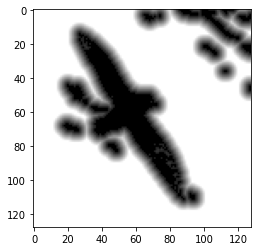

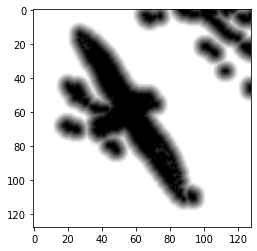

In [148]:
# find distance from the background to foreground
masked_image_distance = np.zeros_like(masked_img)
masked_image_kern_sizes = np.zeros_like(masked_img)

kern_size = lambda sigma: int(round(((sigma-0.8)/0.3+1)*2+1 )) if sigma >0.8 else 0

for i in tqdm(range(r)):
    for j in range(c):
        distance_min = 9999999
        for k in foreground_pixels:
            if ((i-k[0])**2+(j-k[1])**2)<distance_min**2:
                distance_min = np.sqrt((i-k[0])**2+(j-k[1])**2)
                masked_image_distance[i,j,:] = distance_min
                masked_image_kern_sizes[i,j,:] = kern_size(distance_min)
        if distance_min>=6.99:
            masked_image_distance[i,j,:] = 6.99
            masked_image_kern_sizes[i,j,:] = kern_size(6.99)
        

plt.figure()
plt.imshow(masked_image_distance/masked_image_distance.max())
plt.figure()
plt.imshow(masked_image_kern_sizes/masked_image_kern_sizes.max())

In [149]:
print(np.min(masked_image_kern_sizes))
print(np.unique(masked_image_kern_sizes))

0.0
[ 0.  4.  7. 11. 13. 17. 18. 19. 22. 24. 25. 26. 27. 31. 32. 34. 35. 37.
 38. 40. 42. 44.]


In [226]:
from numpy import sqrt,e,power,linspace,outer,pi

def dnorm(x,mu,sigma):
    return 1 / (sqrt(2 * pi) * sigma) * e ** (-power((x - mu) / sigma, 2) / 2)

def gaussian_kernel(ksize,mu=0,sigma=1,verbose=False):
    # create the 1-D gaussian kernel
    if ksize%2==0:
        ksize = ksize-1
    
    kernel_1D = linspace(-(ksize // 2), ksize // 2, ksize)
    for i in range(ksize):
        kernel_1D[i] = dnorm(kernel_1D[i], mu, sigma)

    # computers outer product of two 1-D gaussian kernels
    # to produce a 2D Gaussian Kernel
    kernel_2D = outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()
    return kernel_2D


def convolution(image, kernel_distances,kernel_sizes):
    #print("Kernel Shape : {}".format(kernel.shape))

    # EXTRACTING THE IMAGE AND KERNEL SHAPES AND INITIALIZING OUTPUT
    image_row, image_col,dim = image.shape
    print(image_row,image_col)
    output = np.zeros_like(image)
    # CREATING ZERO-PADDED IMAGE
    
    #pad_height = 50
    #pad_width = 50
    
    #padded_image = np.ones((image_row + (2 * pad_height), image_col + (2 * pad_width),3))*image[0,0,:]
    #for i in range(3):
    #    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width,i] = image[:,:,i]
        
        #padded_image[0:pad_height,0:pad_width,:] = image[]
    
    #padded_image = padded_image/np.max(padded_image)
    #padded_height,padded_width,_ = padded_image.shape
    
    #plt.figure()
    #plt.imshow(padded_image/np.max(padded_image))
    
    #print(padded_image.shape)
    
    #print(padded_height-pad_height-1,padded_width-pad_width-1)
    #print(padded_image.shape[0] - pad_height,padded_image.shape[1] - pad_width)
    
    #for row in tqdm(range(pad_height,padded_height-pad_height-1)):
        #for col in range(pad_width,padded_width-pad_width-1):
    for row in tqdm(range(image_row)):
        for col in range(image_col):
            #print(kernel_sizes[row,col,0])
            #print(row-25,col-25)
#             if kernel_sizes[row-pad_height,col-pad_width,0]>2:
#                 kernel = gaussian_kernel(int(kernel_sizes[row-pad_height,col-pad_width,0]),kernel_distances[row-pad_height,col-pad_width,0])
#                 kernel_row, kernel_col = kernel.shape
#                 output[row-pad_height, col-pad_width,:] = cv2.GaussianBlur(padded_image[row:row + kernel_row, col:col + kernel_col,:],(int(kernel_sizes[row-pad_height,col-pad_width,0]),int(kernel_sizes[row-pad_height,col-pad_width,0])),kernel_distances[row-pad_height,col-pad_width,0])
            
            if kernel_sizes[row,col,0]>2:
                kernel = gaussian_kernel(int(kernel_sizes[row,col,0]),kernel_distances[row,col,0])
                kernel_row, kernel_col = kernel.shape
                
                kernel_mid = kernel_row//2
                
                
                min_truncate = min(min(row,image_row-row-1),min(col,image_col-col-1))
                print(kernel_mid,end="  ")
                print(min_truncate, end="  ")
                print(row,col)
                
                if min_truncate>0 and kernel_row<=row and kernel_col<=col:
                    for i in range(3):
                        output[row, col,i] = np.sum(kernel * image[row-kernel_mid:row+kernel_mid+1, col-kernel_mid:col + kernel_mid+1,i])
                
                elif min_truncate>0 and not (kernel_row<=row or kernel_col<=col) :
                    kernel_truncated = kernel[kernel_mid-min_truncate:kernel_mid+min_truncate+1,kernel_mid-min_truncate:kernel_mid+min_truncate+1]
                    kernel_row, kernel_col = kernel_truncated.shape
                    #print(row,,col,kernel_col+col)
                    # check for paddings if necessary
                    print("Kernel Sizes : ",kernel_row,kernel_col)
                    for i in range(3):
                        output[row, col,i] = np.sum(kernel_truncated * image[row-min_truncate:row + min_truncate+1, col-min_truncate:col + min_truncate+1,i])
                else:
                    output[row, col,:] = image[row,col,:]
            else:
                output[row, col,:] = image[row,col,:]

    return output

In [227]:
gaussian_blurred = convolution(resized_orig,masked_image_distance,masked_image_kern_sizes)
plt.figure()
plt.imshow(gaussian_blurred/np.max(gaussian_blurred))

  2%|▏         | 2/128 [00:00<00:10, 11.65it/s]

128 128
21  0  0 0
21  0  0 1
21  0  0 2
21  0  0 3
21  0  0 4
21  0  0 5
21  0  0 6
21  0  0 7
21  0  0 8
21  0  0 9
21  0  0 10
21  0  0 11
21  0  0 12
21  0  0 13
21  0  0 14
21  0  0 15
21  0  0 16
21  0  0 17
21  0  0 18
21  0  0 19
21  0  0 20
21  0  0 21
21  0  0 22
21  0  0 23
21  0  0 24
21  0  0 25
21  0  0 26
21  0  0 27
21  0  0 28
21  0  0 29
21  0  0 30
21  0  0 31
21  0  0 32
21  0  0 33
21  0  0 34
21  0  0 35
21  0  0 36
21  0  0 37
21  0  0 38
21  0  0 39
21  0  0 40
21  0  0 41
21  0  0 42
21  0  0 43
21  0  0 44
21  0  0 45
21  0  0 46
21  0  0 47
21  0  0 48
21  0  0 49
21  0  0 50
21  0  0 51
21  0  0 52
21  0  0 53
21  0  0 54
21  0  0 55
21  0  0 56
21  0  0 57
21  0  0 58
20  0  0 59
18  0  0 60
15  0  0 61
12  0  0 62
10  0  0 63
9  0  0 64
8  0  0 65
8  0  0 66
8  0  0 67
9  0  0 68
10  0  0 69
12  0  0 70
11  0  0 71
10  0  0 72
9  0  0 73
8  0  0 74
9  0  0 75
10  0  0 76
12  0  0 77
15  0  0 78
18  0  0 79
18  0  0 80
15  0  0 81
11  0  0 82
8  0  0 83
5  

  2%|▏         | 3/128 [00:00<00:11, 11.04it/s]

  2  2 34
Kernel Sizes :  5 5
21  2  2 35
Kernel Sizes :  5 5
21  2  2 36
Kernel Sizes :  5 5
21  2  2 37
Kernel Sizes :  5 5
21  2  2 38
Kernel Sizes :  5 5
21  2  2 39
Kernel Sizes :  5 5
21  2  2 40
Kernel Sizes :  5 5
21  2  2 41
Kernel Sizes :  5 5
21  2  2 42
Kernel Sizes :  5 5
21  2  2 43
21  2  2 44
21  2  2 45
21  2  2 46
21  2  2 47
21  2  2 48
21  2  2 49
21  2  2 50
21  2  2 51
21  2  2 52
21  2  2 53
21  2  2 54
21  2  2 55
21  2  2 56
21  2  2 57
21  2  2 58
18  2  2 59
15  2  2 60
12  2  2 61
9  2  2 62
6  2  2 63
3  2  2 64
1  2  2 65
1  2  2 66
1  2  2 67
3  2  2 68
5  2  2 69
6  2  2 70
5  2  2 71
6  2  2 72
3  2  2 73
1  2  2 74
3  2  2 75
6  2  2 76
9  2  2 77
12  2  2 78
15  2  2 79
18  2  2 80
16  2  2 81
13  2  2 82
10  2  2 83
8  2  2 84
6  2  2 85
3  2  2 86
1  2  2 87
1  2  2 97
1  2  2 98
1  2  2 107
5  2  2 108
8  2  2 109
6  2  2 110
3  2  2 111
1  2  2 112
1  2  2 114
5  2  2 115
5  2  2 116
5  2  2 117
6  2  2 118
8  2  2 119
6  2  2 120
5  2  2 121
5  2

  5%|▍         | 6/128 [00:00<00:13,  9.36it/s]

9
21  4  4 17
Kernel Sizes :  9 9
21  4  4 18
Kernel Sizes :  9 9
21  4  4 19
Kernel Sizes :  9 9
21  4  4 20
Kernel Sizes :  9 9
21  4  4 21
Kernel Sizes :  9 9
21  4  4 22
Kernel Sizes :  9 9
21  4  4 23
Kernel Sizes :  9 9
21  4  4 24
Kernel Sizes :  9 9
21  4  4 25
Kernel Sizes :  9 9
21  4  4 26
Kernel Sizes :  9 9
21  4  4 27
Kernel Sizes :  9 9
21  4  4 28
Kernel Sizes :  9 9
21  4  4 29
Kernel Sizes :  9 9
21  4  4 30
Kernel Sizes :  9 9
21  4  4 31
Kernel Sizes :  9 9
21  4  4 32
Kernel Sizes :  9 9
21  4  4 33
Kernel Sizes :  9 9
21  4  4 34
Kernel Sizes :  9 9
21  4  4 35
Kernel Sizes :  9 9
21  4  4 36
Kernel Sizes :  9 9
21  4  4 37
Kernel Sizes :  9 9
21  4  4 38
Kernel Sizes :  9 9
21  4  4 39
Kernel Sizes :  9 9
21  4  4 40
Kernel Sizes :  9 9
21  4  4 41
Kernel Sizes :  9 9
21  4  4 42
Kernel Sizes :  9 9
21  4  4 43
21  4  4 44
21  4  4 45
21  4  4 46
21  4  4 47
21  4  4 48
21  4  4 49
21  4  4 50
21  4  4 51
21  4  4 52
21  4  4 53
21  4  4 54
21  4  4 55
21  4  4 5

  5%|▌         | 7/128 [00:00<00:13,  8.87it/s]

21  4  6 4
Kernel Sizes :  9 9
21  5  6 5
Kernel Sizes :  11 11
21  6  6 6
Kernel Sizes :  13 13
21  6  6 7
Kernel Sizes :  13 13
21  6  6 8
Kernel Sizes :  13 13
21  6  6 9
Kernel Sizes :  13 13
21  6  6 10
Kernel Sizes :  13 13
21  6  6 11
Kernel Sizes :  13 13
21  6  6 12
Kernel Sizes :  13 13
21  6  6 13
Kernel Sizes :  13 13
21  6  6 14
Kernel Sizes :  13 13
21  6  6 15
Kernel Sizes :  13 13
21  6  6 16
Kernel Sizes :  13 13
21  6  6 17
Kernel Sizes :  13 13
21  6  6 18
Kernel Sizes :  13 13
21  6  6 19
Kernel Sizes :  13 13
21  6  6 20
Kernel Sizes :  13 13
21  6  6 21
Kernel Sizes :  13 13
21  6  6 22
Kernel Sizes :  13 13
21  6  6 23
Kernel Sizes :  13 13
21  6  6 24
Kernel Sizes :  13 13
21  6  6 25
Kernel Sizes :  13 13
21  6  6 26
Kernel Sizes :  13 13
21  6  6 27
Kernel Sizes :  13 13
21  6  6 28
Kernel Sizes :  13 13
21  6  6 29
Kernel Sizes :  13 13
21  6  6 30
Kernel Sizes :  13 13
21  6  6 31
Kernel Sizes :  13 13
21  6  6 32
Kernel Sizes :  13 13
21  6  6 33
Kernel Siz

  7%|▋         | 9/128 [00:01<00:14,  7.94it/s]

7 63
8  7  7 64
6  7  7 65
5  7  7 66
3  7  7 67
1  7  7 68
3  7  7 69
5  7  7 70
6  7  7 71
8  7  7 72
9  7  7 73
8  7  7 74
9  7  7 75
10  7  7 76
12  7  7 77
15  7  7 78
18  7  7 79
20  7  7 80
21  7  7 81
21  7  7 82
21  7  7 83
19  7  7 84
18  7  7 85
16  7  7 86
15  7  7 87
15  7  7 88
15  7  7 89
13  7  7 90
12  7  7 91
11  7  7 92
11  7  7 93
11  7  7 94
11  7  7 95
11  7  7 96
12  7  7 97
12  7  7 98
10  7  7 99
8  7  7 100
6  7  7 101
5  7  7 102
3  7  7 103
1  7  7 104
1  7  7 109
3  7  7 110
6  7  7 111
8  7  7 112
10  7  7 113
12  7  7 114
15  7  7 115
18  7  7 116
15  7  7 117
12  7  7 118
10  7  7 119
8  7  7 120
6  6  7 121
3  5  7 122
1  4  7 123
1  3  7 124
1  2  7 125
1  1  7 126
3  0  7 127
21  0  8 0
21  1  8 1
Kernel Sizes :  3 3
21  2  8 2
Kernel Sizes :  5 5
21  3  8 3
Kernel Sizes :  7 7
21  4  8 4
Kernel Sizes :  9 9
21  5  8 5
Kernel Sizes :  11 11
21  6  8 6
Kernel Sizes :  13 13
21  7  8 7
Kernel Sizes :  15 15
21  8  8 8
Kernel Sizes :  17 17
21  8  8 9
Ke

  8%|▊         | 10/128 [00:01<00:15,  7.49it/s]

  9  9 14
Kernel Sizes :  19 19
21  9  9 15
Kernel Sizes :  19 19
21  9  9 16
Kernel Sizes :  19 19
21  9  9 17
Kernel Sizes :  19 19
21  9  9 18
Kernel Sizes :  19 19
21  9  9 19
Kernel Sizes :  19 19
21  9  9 20
Kernel Sizes :  19 19
21  9  9 21
Kernel Sizes :  19 19
21  9  9 22
Kernel Sizes :  19 19
19  9  9 23
Kernel Sizes :  19 19
18  9  9 24
Kernel Sizes :  19 19
16  9  9 25
Kernel Sizes :  19 19
15  9  9 26
Kernel Sizes :  19 19
15  9  9 27
Kernel Sizes :  19 19
15  9  9 28
Kernel Sizes :  19 19
16  9  9 29
Kernel Sizes :  19 19
18  9  9 30
Kernel Sizes :  19 19
19  9  9 31
Kernel Sizes :  19 19
20  9  9 32
Kernel Sizes :  19 19
21  9  9 33
Kernel Sizes :  19 19
21  9  9 34
Kernel Sizes :  19 19
21  9  9 35
Kernel Sizes :  19 19
21  9  9 36
Kernel Sizes :  19 19
21  9  9 37
Kernel Sizes :  19 19
21  9  9 38
Kernel Sizes :  19 19
21  9  9 39
Kernel Sizes :  19 19
21  9  9 40
Kernel Sizes :  19 19
21  9  9 41
Kernel Sizes :  19 19
21  9  9 42
Kernel Sizes :  19 19
21  9  9 43
21  

  9%|▉         | 12/128 [00:01<00:14,  8.00it/s]

21  10  10 56
21  10  10 57
21  10  10 58
21  10  10 59
21  10  10 60
21  10  10 61
19  10  10 62
18  10  10 63
16  10  10 64
15  10  10 65
13  10  10 66
12  10  10 67
11  10  10 68
12  10  10 69
13  10  10 70
15  10  10 71
16  10  10 72
18  10  10 73
18  10  10 74
18  10  10 75
19  10  10 76
20  10  10 77
21  10  10 78
21  10  10 79
21  10  10 80
21  10  10 81
21  10  10 82
21  10  10 83
21  10  10 84
21  10  10 85
21  10  10 86
21  10  10 87
21  10  10 88
21  10  10 89
21  10  10 90
21  10  10 91
21  10  10 92
21  10  10 93
21  10  10 94
21  10  10 95
21  10  10 96
21  10  10 97
19  10  10 98
18  10  10 99
16  10  10 100
15  10  10 101
12  10  10 102
10  10  10 103
8  10  10 104
6  10  10 105
3  10  10 106
1  10  10 107
1  10  10 112
5  10  10 113
8  10  10 114
9  10  10 115
10  10  10 116
12  10  10 117
15  9  10 118
16  8  10 119
15  7  10 120
13  6  10 121
12  5  10 122
11  4  10 123
11  3  10 124
11  2  10 125
11  1  10 126
12  0  10 127
21  0  11 0
21  1  11 1
Kernel Sizes :  3 

 11%|█         | 14/128 [00:01<00:13,  8.39it/s]

  12 43
21  12  12 44
21  12  12 45
21  12  12 46
21  12  12 47
21  12  12 48
21  12  12 49
21  12  12 50
21  12  12 51
21  12  12 52
21  12  12 53
21  12  12 54
21  12  12 55
21  12  12 56
21  12  12 57
21  12  12 58
21  12  12 59
21  12  12 60
21  12  12 61
21  12  12 62
21  12  12 63
21  12  12 64
20  12  12 65
19  12  12 66
18  12  12 67
18  12  12 68
18  12  12 69
19  12  12 70
20  12  12 71
21  12  12 72
21  12  12 73
21  12  12 74
21  12  12 75
21  12  12 76
21  12  12 77
21  12  12 78
21  12  12 79
21  12  12 80
21  12  12 81
21  12  12 82
21  12  12 83
21  12  12 84
21  12  12 85
21  12  12 86
21  12  12 87
21  12  12 88
21  12  12 89
21  12  12 90
21  12  12 91
21  12  12 92
21  12  12 93
21  12  12 94
21  12  12 95
21  12  12 96
21  12  12 97
21  12  12 98
21  12  12 99
21  12  12 100
19  12  12 101
17  12  12 102
15  12  12 103
12  12  12 104
10  12  12 105
8  12  12 106
6  12  12 107
3  12  12 108
1  12  12 109
1  12  12 113
1  12  12 114
3  12  12 115
6  11  12 116
8  10 

 12%|█▏        | 15/128 [00:01<00:13,  8.55it/s]

25 25
21  13  14 13
Kernel Sizes :  27 27
21  14  14 14
Kernel Sizes :  29 29
21  14  14 15
Kernel Sizes :  29 29
21  14  14 16
Kernel Sizes :  29 29
21  14  14 17
Kernel Sizes :  29 29
21  14  14 18
Kernel Sizes :  29 29
21  14  14 19
Kernel Sizes :  29 29
21  14  14 20
Kernel Sizes :  29 29
18  14  14 21
Kernel Sizes :  29 29
15  14  14 22
Kernel Sizes :  29 29
11  14  14 23
8  14  14 24
5  14  14 25
1  14  14 26
1  14  14 28
1  14  14 29
3  14  14 30
5  14  14 31
6  14  14 32
8  14  14 33
10  14  14 34
12  14  14 35
15  14  14 36
16  14  14 37
18  14  14 38
19  14  14 39
21  14  14 40
Kernel Sizes :  29 29
21  14  14 41
Kernel Sizes :  29 29
21  14  14 42
Kernel Sizes :  29 29
21  14  14 43
21  14  14 44
21  14  14 45
21  14  14 46
21  14  14 47
21  14  14 48
21  14  14 49
21  14  14 50
21  14  14 51
21  14  14 52
21  14  14 53
21  14  14 54
21  14  14 55
21  14  14 56
21  14  14 57
21  14  14 58
21  14  14 59
21  14  14 60
21  14  14 61
21  14  14 62
21  14  14 63
21  14  14 64
21 

 12%|█▏        | 15/128 [00:01<00:14,  7.92it/s]

  8  15 119
1  7  15 120
3  6  15 121
6  5  15 122


ValueError: operands could not be broadcast together with shapes (13,13) (13,12) 